In [1]:
from dotenv import load_dotenv
load_dotenv()
import openai
import json
import os
import random
random.seed(42)
from tqdm import tqdm
import time
import tiktoken
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from classifier_experiments.experiment_utils import load_json_data

In [2]:
# Set up your OpenAI API credentials
AZURE_OPENAI_SERVICE = os.environ.get("AZURE_OPENAI_SERVICE") or ""
AZURE_OPENAI_API_KEY = os.environ.get("AZURE_OPENAI_API_KEY") or ""
AZURE_OPENAI_MODEL_NAME = os.environ.get("AZURE_OPENAI_MODEL_NAME") or "gpt-35-turbo"
AZURE_OPENAI_DEPLOYMENT_NAME = os.environ.get("AZURE_OPENAI_DEPLOYMENT_NAME") or "gpt-35-turbo"

OPENAI_API_VERSION = os.environ.get("OPENAI_API_VERSION") or "2023-07-01-preview"

openai.api_type = "azure"
openai.api_base = f"https://{AZURE_OPENAI_SERVICE}.openai.azure.com/"
openai.api_version = OPENAI_API_VERSION
openai.api_key = AZURE_OPENAI_API_KEY

CONTEXT_LENGTH = 16384

In [3]:
def generate_response(messages):
    try:
        completion = openai.ChatCompletion.create(
            engine=AZURE_OPENAI_DEPLOYMENT_NAME, 
            messages=messages, 
            temperature=1,
            stop=None, 
            presence_penalty=1
        )
    except Exception as e:
        print("Error generating response:", e)
        return ""
    return completion.choices[0].message.content

In [4]:
def load_raw_articles(filename):
    articles = []
    with open(filename) as file:
        json_list = list(file)
        for json_str in json_list:
            article = json.loads(json_str)
            articles.append(article)
    return articles

In [5]:
def get_templates(categories, title, section):
    categories_enumerated = "\n".join([f"- {cat}" for idx, cat in enumerate(categories)])
    system_template = f'''
Your task is to classify sections of a news article into specific categories. These categories encompass a range of topics, such as artificial intelligence, autonomous transport, sustainable fabrics, and more. However, it can be challenging to clearly differentiate between these categories at times, as some articles may cover multiple topics. For instance, artificial intelligence might play a significant role in autonomous driving, drones, and various other applications. However, an article should only be labeled as "artificial intelligence" if this topic is the primary focus and not just a supporting element for another topic. A similar example can be made with "3D Printed Clothes" and "Sustainable fabrics". These are the available categories:
{categories_enumerated}
'''
    prompt_template = f'''
Please categorize the following article segment by selecting the most appropriate category from the provided list. Your response should only include the category name. If you are uncertain, please reply with "unsure". If you believe the section lacks relevant information for any category, respond with "irrelevant". Do not use any other responses.
Article title: {title}
Segment: {section}
'''
    return system_template, prompt_template

In [6]:
def truncate_messages(messages):
    encoder = tiktoken.encoding_for_model("gpt-3.5-turbo")
    total_length = 0
    for msg in messages:
        total_length += len(encoder.encode(msg['content']))
    if total_length >= CONTEXT_LENGTH - 100:
        messages[-1]['content'] = encoder.decode(encoder.encode(messages[-1]['content'])[:(CONTEXT_LENGTH-total_length)-100])
    return messages

In [7]:
annotated_sections = load_json_data('../data/')
annotated_categories = list(annotated_sections.label.unique())

raw_articles = load_raw_articles('../data/raw_data.jsonl')
annotated_articles = [article for article in raw_articles if article['category'].lower() in [cat for cat in annotated_categories]]

Loaded: 3d_printed_clothes_sentences.jsonl
Loaded: cement_production_sentences.jsonl
Loaded: organic_food_sentences.jsonl
Loaded: shipping_sentences.jsonl
Loaded: sustainable_fabrics_sentences.jsonl
Loaded: artificial_intelligence_sentences.jsonl
Loaded: clothes_designed_for_a_circular_economy_sentences.jsonl
Loaded: autonomous_transport_sentences.jsonl
Loaded: fiber_optic_cables_sentences.jsonl
Loaded: electric_car_sentences.jsonl
Loaded: drone_sentences.jsonl
Loaded: e_health_sentences.jsonl
Loaded: capsule_wardrobe_sentences.jsonl
Loaded: car_sharing_sentences.jsonl
Loaded: smart_food_management_kitchen_fridges_freezers_sentences.jsonl
Loaded: biking_sentences.jsonl
Loaded: rent_apparel_sentences.jsonl


In [8]:
def split_article_into_sections(article, section_length=3, by="sentences"):
    # get the first three sentences in the article
    if by == "sentences":
        sentences = article['text'].split('.')
        sections = []
        for i in range(0, len(sentences), section_length):
            sections.append('.'.join(sentences[i:i+section_length]))
        return sections
    elif by == "words":
        words = article['text'].split(' ')
        sections = []
        for i in range(0, len(words), section_length):
            sections.append(' '.join(words[i:i+section_length]))
        return sections
    else:
        raise ValueError("by must be either 'sentences' or 'words'")

In [9]:
def classify_sections(sections, categories):
    invalid_responses = []
    predictions = []
    for idx, section in sections.iterrows():
        system_template, prompt_template = get_templates(categories, section.title, section.text)
        messages = [
            {"role":"system","content": system_template},
            {"role": "user", "content": prompt_template}
        ]
        messages = truncate_messages(messages)
        response = generate_response(messages).strip().replace('.', '').lower()
        second_prediction = response
        if response not in annotated_categories + ['unsure','irrelevant']:
            invalid_responses.append(response)
            messages.append({"role": "assistant", "content": response})
            messages.append({"role": "user", "content": 'Your response is not valid. It does not match any of the provided categories, "unsure" or "irrelevant". Please try again.'})
            second_prediction = generate_response(messages).replace('.', '').lower()
        predictions.append({
            "section": section.text,
            "prediction": response,
            "second_prediction": second_prediction,
            "annotation": section.answer,
            "title": section.title
            })
    return predictions, invalid_responses

# Get Predictions

In [10]:
# example prompt
example_system_prompt, example_prompt = get_templates(annotated_categories, annotated_sections.iloc[0]["title"], annotated_sections.iloc[0]["text"])
print(example_system_prompt)
print(example_prompt)


Your task is to classify sections of a news article into specific categories. These categories encompass a range of topics, such as artificial intelligence, autonomous transport, sustainable fabrics, and more. However, it can be challenging to clearly differentiate between these categories at times, as some articles may cover multiple topics. For instance, artificial intelligence might play a significant role in autonomous driving, drones, and various other applications. However, an article should only be labeled as "artificial intelligence" if this topic is the primary focus and not just a supporting element for another topic. A similar example can be made with "3D Printed Clothes" and "Sustainable fabrics". These are the available categories:
- 3d_printed_clothes
- cement_production
- organic_food
- shipping
- sustainable_fabrics
- artificial_intelligence
- clothes_designed_for_a_circular_economy
- autonomous_transport
- fiber_optic_cables
- electric_car
- drone
- e_health
- capsule

In [11]:
predictions = []
invalid_responses = []
num_articles = 25
num_sections_per_article = 15
progressbar = tqdm(total=len(annotated_categories)*num_articles*num_sections_per_article, position=0, leave=True)
for cat in annotated_categories:
    progressbar.set_description(cat)
    sub = annotated_sections[annotated_sections.label == cat]
    # sample 15 article ids from sub
    num_articles_in_category = len(sub.article_id.unique())
    article_ids = sub.article_id.sample(num_articles if num_articles <= num_articles_in_category else num_articles_in_category).values
    for id in article_ids:
        sub_article = sub[sub.article_id == id]
        sections = sub_article.sample(num_sections_per_article if num_sections_per_article <= len(sub_article) else len(sub_article))
        article_predictions, sub_invalid_responses = classify_sections(sections, annotated_categories)
        invalid_responses += sub_invalid_responses
        for pred in article_predictions:
            pred["article_id"] = id
            pred["category"] = cat
        predictions += article_predictions
        progressbar.update(num_sections_per_article)
predictions = pd.DataFrame(predictions)
print("Invalid Responses:", invalid_responses)

rent_apparel:  64%|██████▍   | 4065/6375 [13:19<04:58,  7.75it/s]                                  

Invalid Responses: ['sustainable_shipping', 'sustainable_shipping', 'sustainable_shipping', 'sustainable_shipping', 'sustainable_shipping', 'sustainable_shipping', 'sustainable_shipping', 'climate_change', 'carbon_tax', 'climate_change', 'climate_change', 'circular_economy', 'autonomous transport', 'sustainable_transport', 'sustainable_lighting', 'sustainable_agriculture', 'sustainable_agriculture', 'sustainable_agriculture', 'sustainable_agriculture', 'drones', 'drones', 'drones', 'autonomous_transport (irrelevant)', "autonomous_transport (i'm assuming this is referring to shared ride services, which could fall under the category of autonomous transport)", 'autonomous_transport (irrelevant for all categories)', 'autonomous_transport (irrelevant if autonomous transport is limited to self-driving cars)', 'autonomous_transport (unsure)', 'autonomous_transport (this is the closest category, as there is no specific carpooling category provided however, this article focuses on carpooling an

## Process Predictions

In [12]:
predictions["prediction_after_processing"] = predictions["second_prediction"]

In [13]:
predictions["match_after_first"] = predictions["category"] == predictions["prediction"]
predictions["match_after_second"] = predictions["category"] == predictions["second_prediction"]

In [14]:
unsure_irrelevant_predictions = predictions[predictions.second_prediction.isin(['unsure', 'irrelevant'])]
# get all predictions where the second prediction is not in the annotated categories or unsure
ambiguous_predictions = predictions[predictions.second_prediction.isin(annotated_categories + ['unsure']) == False]

In [15]:
# process ambiguous predictions
if len(ambiguous_predictions) > 0:
    print(f"Found {len(ambiguous_predictions)} ambiguous predictions")
    for idx, row in ambiguous_predictions.iterrows():
        print(f"Ambiguous prediction: '{row.prediction}' and '{row.second_prediction}'")
        for cat in annotated_categories:
            if cat in row.prediction or cat in row.second_prediction:
                print(f"predictions were '{row.prediction}' and '{row.second_prediction}' -> but likely '{row.category}' was meant")
                predictions.loc[idx, "prediction_after_processing"] = cat
else:
    print("No ambiguous predictions found")

Found 96 ambiguous predictions
Ambiguous prediction: 'irrelevant' and 'irrelevant'
Ambiguous prediction: 'irrelevant' and 'irrelevant'
Ambiguous prediction: 'sustainable_shipping' and 'sustainable_shipping'
predictions were 'sustainable_shipping' and 'sustainable_shipping' -> but likely 'shipping' was meant
Ambiguous prediction: 'sustainable_shipping' and 'irrelevant'
predictions were 'sustainable_shipping' and 'irrelevant' -> but likely 'shipping' was meant
Ambiguous prediction: 'sustainable_shipping' and 'irrelevant'
predictions were 'sustainable_shipping' and 'irrelevant' -> but likely 'shipping' was meant
Ambiguous prediction: 'sustainable_shipping' and 'irrelevant'
predictions were 'sustainable_shipping' and 'irrelevant' -> but likely 'shipping' was meant
Ambiguous prediction: 'sustainable_shipping' and 'irrelevant'
predictions were 'sustainable_shipping' and 'irrelevant' -> but likely 'shipping' was meant
Ambiguous prediction: 'irrelevant' and 'irrelevant'
Ambiguous prediction: '

In [20]:
if len(unsure_irrelevant_predictions) > 0:
    print(f"Found {len(unsure_irrelevant_predictions)} 'unsure' predictions:")
    for idx, row in unsure_irrelevant_predictions.iterrows():
        print(f'idx: {idx}')
        print(f'category: {row.category}')
        print(f'title: {row.title}')
        print(f'section: {row.section}')
        print(f'prediction: {row.prediction}')
        print(f'second_prediciton: {row.second_prediction}')
        print(f'annotation: {row.annotation}')
        print(f"")
else:
    print("No unsure predictions found")

Found 103 'unsure' predictions:
idx: 183
category: 3d_printed_clothes
title: Exploration of 3D printing to create zero-waste sustainable fashion notions and jewelry
section: Black, S (2012). Footwear designer Ross Barber in conversation with Sandy Black. Fashion Practice, 4(2), 263–269.
prediction: irrelevant
second_prediciton: irrelevant
annotation: ignore

idx: 325
category: cement_production
title: Investigation of CO2 reduction for sustainable cement manufacturing
section: Check out our other PhDs in Sheffield, United Kingdom
Check out our other PhDs in United Kingdom
Start a New search with our database of over 4,000 PhDs
PhD suggestions
Based on your current search criteria we thought you might be interested in these. A novel approach to the generation and optimisation of sustainable powders for Metal Additive Manufacturing
Cardiff University
Data-driven, systems engineering methodologies for achieving sustainable manufacturing towards a circular economy
The University of Manches

In [21]:
predictions["match_after_processing"] = predictions["category"] == predictions["prediction_after_processing"]
print(f'Accuracy first try: {len(predictions.loc[predictions.match_after_first == True])/len(predictions)*100}%')
print(f'Accuracy second try: {len(predictions.loc[predictions.match_after_second == True])/len(predictions)*100}%')
print(f'Accuracy after processing: {len(predictions.loc[predictions.match_after_processing == True])/len(predictions)*100}%')

Accuracy first try: 91.29981766084919%
Accuracy second try: 91.35191456108362%
Accuracy after processing: 91.56030216202136%


In [22]:
def plot_confusion_matrix(df, title="Confusion Matrix"):
    cm = confusion_matrix(df['category'], df['prediction_after_processing'], labels=annotated_categories)
    plt.figure(figsize=(8,8))
    g = sns.heatmap(cm, annot=True, fmt='g', xticklabels=annotated_categories , yticklabels=annotated_categories, cmap='Blues')
    g.set_title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

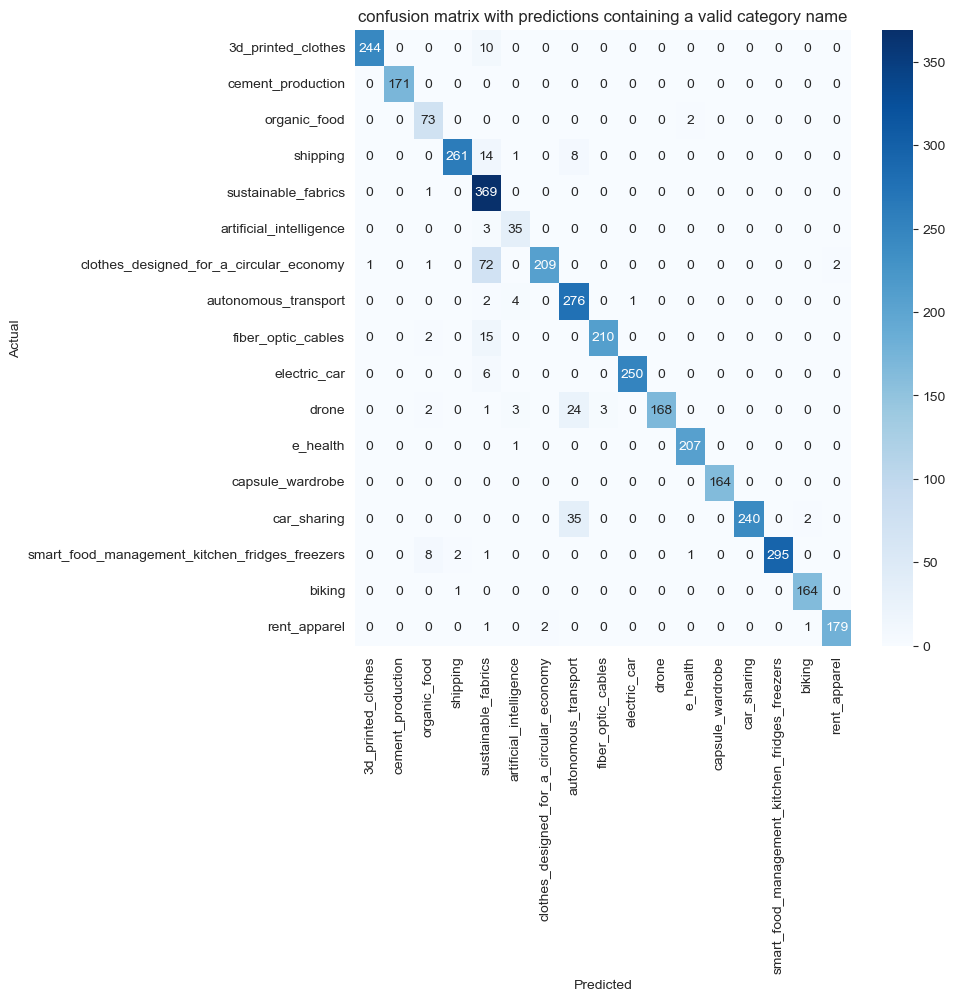

In [23]:
predictions_with_valid_category_name = predictions[predictions.prediction_after_processing.isin(annotated_categories)]
plot_confusion_matrix(predictions_with_valid_category_name, title="confusion matrix with predictions containing a valid category name")